In [1]:
# importing libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import warnings

%config InlineBackend.figure_format='retina'
warnings.filterwarnings("ignore")

/home/lac-user/Madhura/ANACONDA_FOLDER/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# defining functions

def Get_Feature_Importances(pipeline):
    feature_names = pipeline.named_steps['features'].transformer_list[0][1].named_steps['vectorizer'].get_feature_names()
    feature_names.extend(['word_count', 'char_count', 'word_density', 'total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks' ,'num_unique_words', 'words_vs_unique'])
    #print(len(feature_names))
    
    coefficients = pipeline[1].coef_

    importances = []
    for coef in coefficients:
        importances.append(list(coefficients[0]))
    importances = importances[0]
    #print(len(importances))
    #print(importances)
    
    feature_importances = dict()
    for i in range(len(feature_names)):
        feature_importances[feature_names[i]] = importances[i]
        #print(importances[i])

    #print(len(feature_importances))
    #print(feature_importances)
    
    return feature_importances

def Plot_Feature_Importances(feature_importances, top_features=10):
    top_positive_coefficients = dict(sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)[:top_features])
    top_negative_coefficients = dict(sorted(feature_importances.items(), key=lambda x: x[1], reverse=False)[:top_features])
    top_coefficients = {**top_positive_coefficients , **top_negative_coefficients}
    top_coefficients = dict(sorted(top_coefficients.items(), key=lambda x: x[1], reverse=False))
    #type(top_coefficients)
    #top_coefficients

    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in top_coefficients.values()]
    plt.bar(np.arange(2 * top_features)+1, top_coefficients.values(), color=colors)
    feature_names = list(top_coefficients.keys())
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names, rotation=60, ha='right')
    plt.title('Feature Importances')
    plt.show()

In [3]:
# read the data

df = pd.read_csv('sampdf_feat.csv')
df.shape

(54870, 19)

In [4]:
# Create X and y dataframe

X = df.loc[:, ['cleaned_comment_text', 'word_count', 'char_count', 'word_density', 'total_length',
               'capitals', 'caps_vs_length', 'num_exclamation_marks', 'num_unique_words', 'words_vs_unique'
               ]]
y = df['toxic']

In [5]:
#Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2019)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (43896, 10)
y_train: (43896,)
X_test: (10974, 10)
y_test: (10974,)


In [6]:
# define classes for selecting features

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [7]:
# creating separate Pipelines for each feature

word_count =  Pipeline([
                ('selector', NumberSelector(key='word_count')),
                ('standard', StandardScaler())
            ])

word_count.fit_transform(X_train)

char_count =  Pipeline([
                ('selector', NumberSelector(key='char_count')),
                ('standard', StandardScaler())
            ])

char_count.fit_transform(X_train)

word_density =  Pipeline([
                ('selector', NumberSelector(key='word_density')),
                ('standard', StandardScaler())
            ])

word_density.fit_transform(X_train)

total_length =  Pipeline([
                ('selector', NumberSelector(key='total_length')),
                ('standard', StandardScaler())
            ])

total_length.fit_transform(X_train)

capitals =  Pipeline([
                ('selector', NumberSelector(key='capitals')),
                ('standard', StandardScaler())
            ])

capitals.fit_transform(X_train)

caps_vs_length =  Pipeline([
                ('selector', NumberSelector(key='caps_vs_length')),
                ('standard', StandardScaler())
            ])

caps_vs_length.fit_transform(X_train)

num_exclamation_marks =  Pipeline([
                ('selector', NumberSelector(key='num_exclamation_marks')),
                ('standard', StandardScaler())
            ])

num_exclamation_marks.fit_transform(X_train)

num_unique_words =  Pipeline([
                ('selector', NumberSelector(key='num_unique_words')),
                ('standard', StandardScaler())
            ])

num_unique_words.fit_transform(X_train)

words_vs_unique =  Pipeline([
                ('selector', NumberSelector(key='words_vs_unique')),
                ('standard', StandardScaler())
            ])

words_vs_unique.fit_transform(X_train)

array([[ 0.78208655],
       [ 0.78208655],
       [ 0.78208655],
       ...,
       [ 0.78208655],
       [-0.89978405],
       [-0.25291074]])

##### USING TF-IDF VECTORIZER

In [8]:
# TF-IDF vectorizer pipeline

text = Pipeline([
            ('selector', TextSelector(key='cleaned_comment_text')),
            ('vectorizer', TfidfVectorizer(stop_words='english'))
        ])

text.fit_transform(X_train)

<43896x71424 sparse matrix of type '<class 'numpy.float64'>'
	with 872005 stored elements in Compressed Sparse Row format>

In [9]:
# creating feature union

feats = FeatureUnion([('text', text), 
                      ('word_count', word_count),
                      ('char_count', char_count),
                      ('word_density', word_density),
                      ('total_length', total_length),
                      ('capitals', capitals), 
                      ('caps_vs_length', caps_vs_length), 
                      ('num_exclamation_marks', num_exclamation_marks), 
                      ('num_unique_words', num_unique_words), 
                      ('words_vs_unique', words_vs_unique)])

feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

<43896x71433 sparse matrix of type '<class 'numpy.float64'>'
	with 1267069 stored elements in Compressed Sparse Row format>

In [10]:
# defining the models

range_C = [0.1, 0.2, 0.5, 1.0, 2.0]
pipelines = []

for C in range_C:
    LR = LogisticRegression(C=C)

    pipeline = Pipeline([
        ('features',feats),
        ('classifier', LR),
    ])
    
    pipelines.append(pipeline)

In [11]:
# train the models

for pipeline in pipelines:
    pipeline.fit(X_train, y_train)

In [12]:
summary = pd.DataFrame(columns=['C', 'Avg Accuracy - Train', 'Micro Precision - Train', 
                                'Micro Recall - Train', 'Micro F1-score - Train',
                                'Avg Accuracy - Test', 'Micro Precision - Test', 
                                'Micro Recall - Test', 'Micro F1-score - Test'])

In [13]:
# predict and evaluate on training data

for i in range(len(pipelines)):
    
    print('Calculating Training Metrics for C = ', range_C[i])
    train_pred = pipelines[i].predict(X_train)

    accuracy = accuracy_score(y_train, train_pred)
    precision, recall, f1_score, support = precision_recall_fscore_support(y_train, train_pred, beta=1, average='weighted')
    
    summary.at[i, 'Avg Accuracy - Train'] = np.round(100*accuracy, 2)
    summary.at[i, 'Micro Precision - Train'] = np.round(100*precision, 2)
    summary.at[i, 'Micro Recall - Train'] = np.round(100*recall, 2)
    summary.at[i, 'Micro F1-score - Train'] = np.round(100*f1_score, 2)
    
    print('Calculating Testing Metrics for C = ', range_C[i])
    test_pred = pipelines[i].predict(X_test)

    accuracy = accuracy_score(y_test, test_pred)
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test, test_pred, beta=1, average='weighted')
    
    summary.at[i, 'C'] = range_C[i]
    summary.at[i, 'Avg Accuracy - Test'] = np.round(100*accuracy, 2)
    summary.at[i, 'Micro Precision - Test'] = np.round(100*precision, 2)
    summary.at[i, 'Micro Recall - Test'] = np.round(100*recall, 2)
    summary.at[i, 'Micro F1-score - Test'] = np.round(100*f1_score, 2)
    
display(summary)

Calculating Training Metrics for C =  0.1
Calculating Testing Metrics for C =  0.1
Calculating Training Metrics for C =  0.2
Calculating Testing Metrics for C =  0.2
Calculating Training Metrics for C =  0.5
Calculating Testing Metrics for C =  0.5
Calculating Training Metrics for C =  1.0
Calculating Testing Metrics for C =  1.0
Calculating Training Metrics for C =  2.0
Calculating Testing Metrics for C =  2.0


,C,Avg Accuracy - Train,Micro Precision - Train,Micro Recall - Train,Micro F1-score - Train,Avg Accuracy - Test,Micro Precision - Test,Micro Recall - Test,Micro F1-score - Test
0,0.1,85.08,85.81,85.08,84.6,84.28,84.78,84.28,83.81
1,0.2,87.36,87.77,87.36,87.08,85.93,86.18,85.93,85.63
2,0.5,89.78,89.94,89.78,89.64,87.46,87.52,87.46,87.29
3,1,91.53,91.6,91.53,91.45,88.14,88.12,88.14,88.03
4,2,93.35,93.36,93.35,93.31,88.36,88.33,88.36,88.28


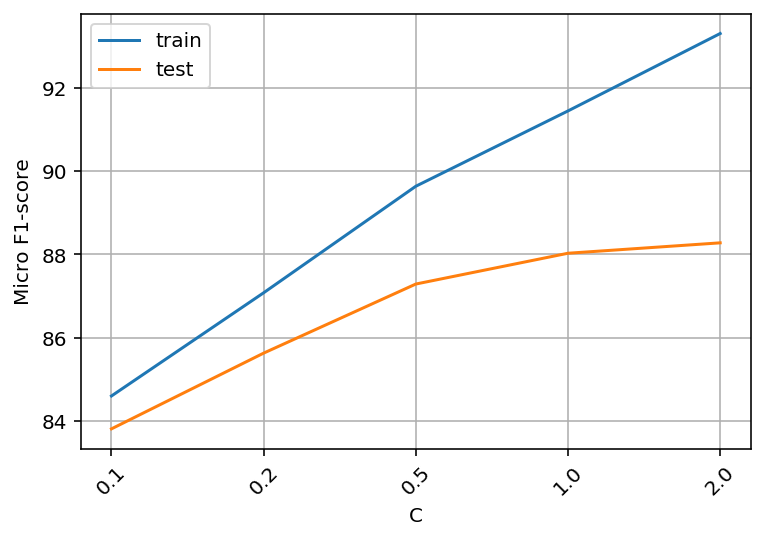

In [14]:
# plot train F1-score and test F1-score

fig = plt.figure(1)
ax  = fig.add_subplot(111)
a = np.arange(len(summary))

plt.plot(summary['Micro F1-score - Train'], label='train')
plt.plot(summary['Micro F1-score - Test'], label='test')
ax.xaxis.set_ticks(a)
ax.xaxis.set_ticklabels(range_C, rotation=45)
plt.xlabel('C')
plt.ylabel('Micro F1-score', rotation=90)
plt.legend()
plt.grid(True)

Since the model starts to overfit and test score remains constant after C = 1.0, we will select 1.0 for C.

Calculating Testing Metrics for C = 1.0

Confusion Matrix:
[[6260  469]
 [ 833 3412]]

Avg Accuracy: 88.14%

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      6729
           1       0.88      0.80      0.84      4245

    accuracy                           0.88     10974
   macro avg       0.88      0.87      0.87     10974
weighted avg       0.88      0.88      0.88     10974

Precision: 88.12%
Recall: 88.14%
F1 score: 88.03%


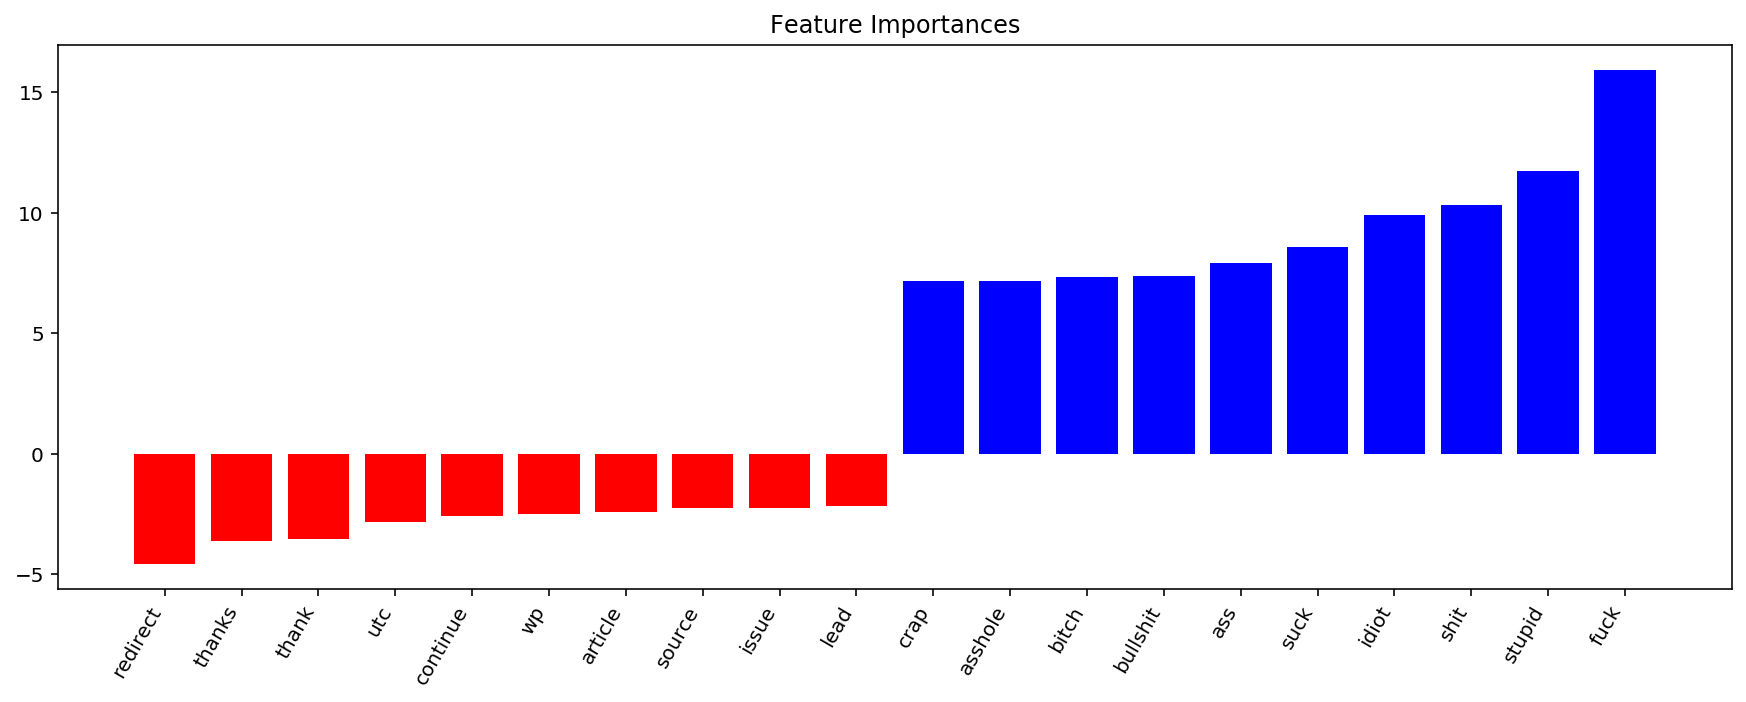

In [16]:
# detailed Test results for C = 1.0

print('Calculating Testing Metrics for C = 1.0')
test_pred = pipelines[3].predict(X_test)    
    
report = """
Confusion Matrix:
{}
\nAvg Accuracy: {}%
""".format(confusion_matrix(y_test, test_pred),
           round(100*accuracy_score(y_test, test_pred), 2))
print(report)

print('Classification Report:')
print(classification_report(y_test, test_pred))

precision, recall, f1_score, support = precision_recall_fscore_support(y_test, test_pred, beta=1, average='weighted')

print("Precision: {}%".format(np.round(100*precision, 2)))
print("Recall: {}%".format(np.round(100*recall, 2)))
print("F1 score: {}%".format(np.round(100*f1_score, 2)))

feature_importances = Get_Feature_Importances(pipelines[3])
Plot_Feature_Importances(feature_importances) 

In [17]:
# saving the model

filename = 'TFIDF_LR_Level_1.joblib'
joblib.dump(pipelines[3], filename)

['TFIDF_LR_Level_1.joblib']

##### USING BINARY VECTORIZER

In [18]:
# Binary vectorizer pipeline

text = Pipeline([
            ('selector', TextSelector(key='cleaned_comment_text')),
            ('vectorizer', TfidfVectorizer(stop_words='english', binary=True, use_idf=False, norm=False))
        ])

text.fit_transform(X_train)

<43896x71424 sparse matrix of type '<class 'numpy.float64'>'
	with 872005 stored elements in Compressed Sparse Row format>

In [19]:
# creating feature union

feats = FeatureUnion([('text', text), 
                      ('word_count', word_count),
                      ('char_count', char_count),
                      ('word_density', word_density),
                      ('total_length', total_length),
                      ('capitals', capitals), 
                      ('caps_vs_length', caps_vs_length), 
                      ('num_exclamation_marks', num_exclamation_marks), 
                      ('num_unique_words', num_unique_words), 
                      ('words_vs_unique', words_vs_unique)])

feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

<43896x71433 sparse matrix of type '<class 'numpy.float64'>'
	with 1267069 stored elements in Compressed Sparse Row format>

In [20]:
# defining the model 

range_C = [0.1, 0.2, 0.5, 1.0, 2.0]
pipelines = []

for C in range_C:
    LR = LogisticRegression(C=C)

    pipeline = Pipeline([
        ('features',feats),
        ('classifier', LR),
    ])
    
    pipelines.append(pipeline)

In [21]:
# train the model

for pipeline in pipelines:
    pipeline.fit(X_train, y_train)

In [22]:
summary = pd.DataFrame(columns=['C', 'Avg Accuracy - Train', 'Micro Precision - Train', 
                                'Micro Recall - Train', 'Micro F1-score - Train',
                                'Avg Accuracy - Test', 'Micro Precision - Test', 
                                'Micro Recall - Test', 'Micro F1-score - Test'])

In [23]:
# predict and evaluate on training data

for i in range(len(pipelines)):
    
    print('Calculating Training Metrics for C = ', range_C[i])
    train_pred = pipelines[i].predict(X_train)

    accuracy = accuracy_score(y_train, train_pred)
    precision, recall, f1_score, support = precision_recall_fscore_support(y_train, train_pred, beta=1, average='weighted')
    
    summary.at[i, 'Avg Accuracy - Train'] = np.round(100*accuracy, 2)
    summary.at[i, 'Micro Precision - Train'] = np.round(100*precision, 2)
    summary.at[i, 'Micro Recall - Train'] = np.round(100*recall, 2)
    summary.at[i, 'Micro F1-score - Train'] = np.round(100*f1_score, 2)
    
    print('Calculating Testing Metrics for C = ', range_C[i])
    test_pred = pipelines[i].predict(X_test)

    accuracy = accuracy_score(y_test, test_pred)
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test, test_pred, beta=1, average='weighted')
    
    summary.at[i, 'C'] = range_C[i]
    summary.at[i, 'Avg Accuracy - Test'] = np.round(100*accuracy, 2)
    summary.at[i, 'Micro Precision - Test'] = np.round(100*precision, 2)
    summary.at[i, 'Micro Recall - Test'] = np.round(100*recall, 2)
    summary.at[i, 'Micro F1-score - Test'] = np.round(100*f1_score, 2)
    
display(summary)

Calculating Training Metrics for C =  0.1
Calculating Testing Metrics for C =  0.1
Calculating Training Metrics for C =  0.2
Calculating Testing Metrics for C =  0.2
Calculating Training Metrics for C =  0.5
Calculating Testing Metrics for C =  0.5
Calculating Training Metrics for C =  1.0
Calculating Testing Metrics for C =  1.0
Calculating Training Metrics for C =  2.0
Calculating Testing Metrics for C =  2.0


,C,Avg Accuracy - Train,Micro Precision - Train,Micro Recall - Train,Micro F1-score - Train,Avg Accuracy - Test,Micro Precision - Test,Micro Recall - Test,Micro F1-score - Test
0,0.1,90.76,90.8,90.76,90.68,87.78,87.78,87.78,87.66
1,0.2,92.22,92.23,92.22,92.17,88.28,88.25,88.28,88.2
2,0.5,94.36,94.36,94.36,94.34,88.37,88.33,88.37,88.31
3,1,95.96,95.96,95.96,95.96,88.35,88.31,88.35,88.3
4,2,97.34,97.34,97.34,97.34,88.27,88.22,88.27,88.23


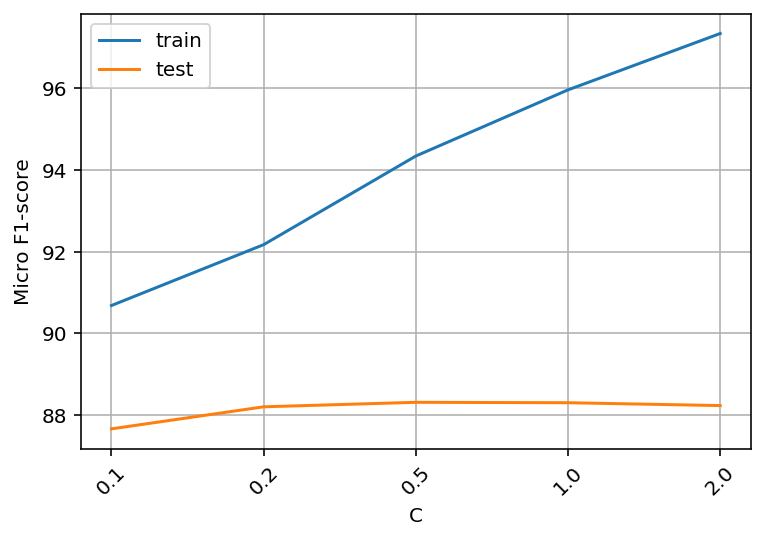

In [24]:
# plot train F1-score and test F1-score

fig = plt.figure(1)
ax  = fig.add_subplot(111)
a = np.arange(len(summary))

plt.plot(summary['Micro F1-score - Train'], label='train')
plt.plot(summary['Micro F1-score - Test'], label='test')
ax.xaxis.set_ticks(a)
ax.xaxis.set_ticklabels(range_C, rotation=45)
plt.xlabel('C')
plt.ylabel('Micro F1-score', rotation=90)
plt.legend()
plt.grid(True)

Since the model starts to overfit and test score remains constant after C = 0.2, we will select 0.2 for C.

Calculating Testing Metrics for C = 0.2

Confusion Matrix:
[[6235  494]
 [ 792 3453]]

Avg Accuracy: 88.28%

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      6729
           1       0.87      0.81      0.84      4245

    accuracy                           0.88     10974
   macro avg       0.88      0.87      0.87     10974
weighted avg       0.88      0.88      0.88     10974

Precision: 88.25%
Recall: 88.28%
F1 score: 88.2%


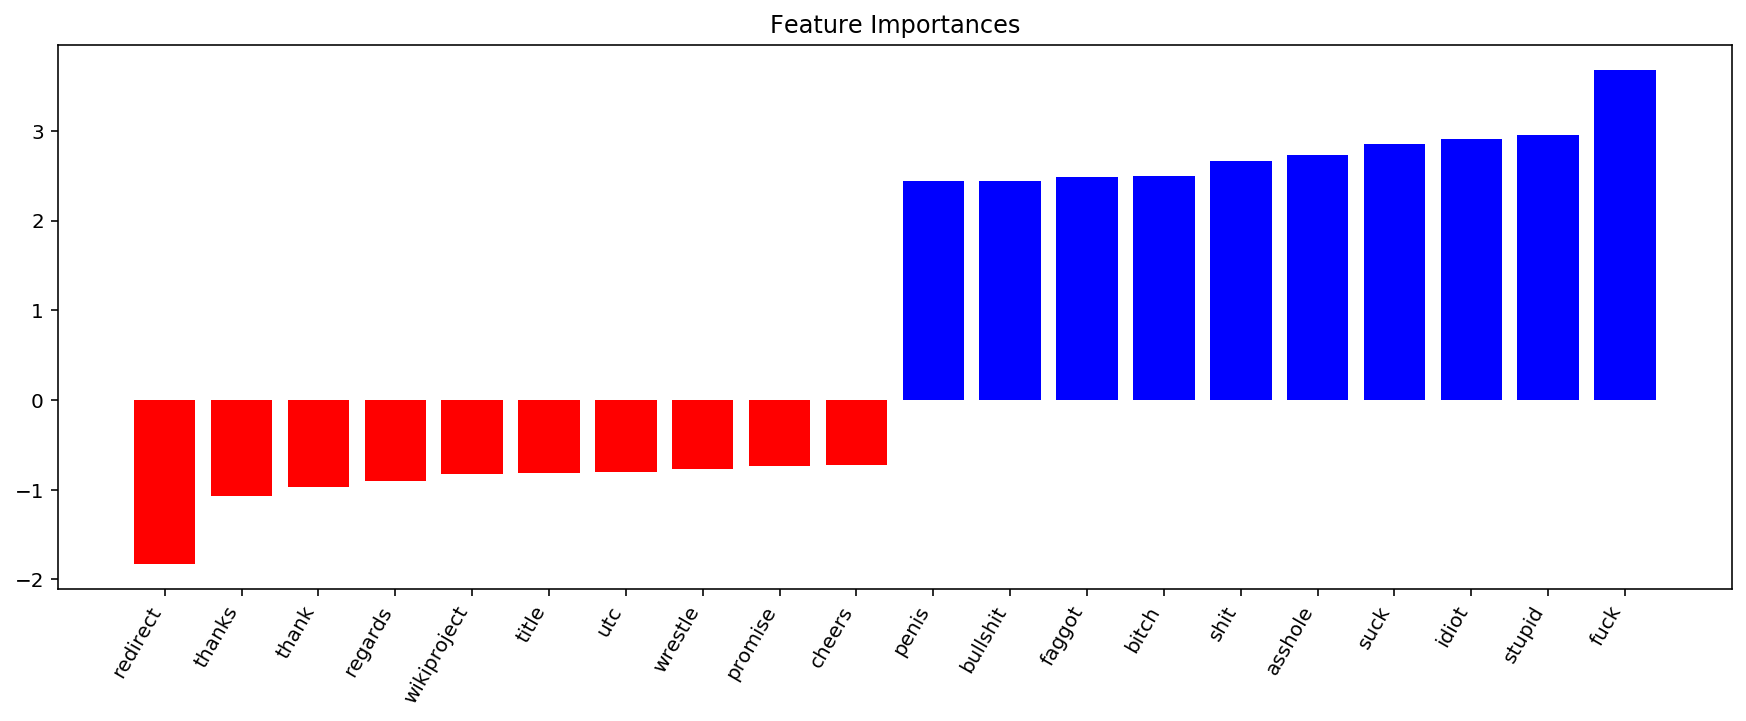

In [25]:
# detailed Test results for C = 0.2

print('Calculating Testing Metrics for C = 0.2')
test_pred = pipelines[1].predict(X_test)    
    
report = """
Confusion Matrix:
{}
\nAvg Accuracy: {}%
""".format(confusion_matrix(y_test, test_pred),
           round(100*accuracy_score(y_test, test_pred), 2))
print(report)

print('Classification Report:')
print(classification_report(y_test, test_pred))

precision, recall, f1_score, support = precision_recall_fscore_support(y_test, test_pred, beta=1, average='weighted')

print("Precision: {}%".format(np.round(100*precision, 2)))
print("Recall: {}%".format(np.round(100*recall, 2)))
print("F1 score: {}%".format(np.round(100*f1_score, 2)))

feature_importances = Get_Feature_Importances(pipelines[1])
Plot_Feature_Importances(feature_importances) 

In [26]:
# saving the model

filename = 'Binary_LR_Level_1.joblib'
joblib.dump(pipelines[1], filename)

['Binary_LR_Level_1.joblib']

##### USING COUNT VECTORIZER

In [27]:
# Count vectorizer pipeline

text = Pipeline([
            ('selector', TextSelector(key='cleaned_comment_text')),
            ('vectorizer', CountVectorizer(stop_words='english'))
        ])

text.fit_transform(X_train)

<43896x71424 sparse matrix of type '<class 'numpy.int64'>'
	with 872005 stored elements in Compressed Sparse Row format>

In [28]:
# creating feature union

feats = FeatureUnion([('text', text), 
                      ('word_count', word_count),
                      ('char_count', char_count),
                      ('word_density', word_density),
                      ('total_length', total_length),
                      ('capitals', capitals), 
                      ('caps_vs_length', caps_vs_length), 
                      ('num_exclamation_marks', num_exclamation_marks), 
                      ('num_unique_words', num_unique_words), 
                      ('words_vs_unique', words_vs_unique)])

feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

<43896x71433 sparse matrix of type '<class 'numpy.float64'>'
	with 1267069 stored elements in Compressed Sparse Row format>

In [29]:
# defining the model 

range_C = [0.1, 0.2, 0.5, 1.0, 2.0]
pipelines = []

for C in range_C:
    LR = LogisticRegression(C=C)

    pipeline = Pipeline([
        ('features',feats),
        ('classifier', LR),
    ])
    
    pipelines.append(pipeline)

In [30]:
# train the model

for pipeline in pipelines:
    pipeline.fit(X_train, y_train)    

In [31]:
summary = pd.DataFrame(columns=['C', 'Avg Accuracy - Train', 'Micro Precision - Train', 
                                'Micro Recall - Train', 'Micro F1-score - Train',
                                'Avg Accuracy - Test', 'Micro Precision - Test', 
                                'Micro Recall - Test', 'Micro F1-score - Test'])

In [32]:
# predict and evaluate on training data

for i in range(len(pipelines)):
    
    print('Calculating Training Metrics for C = ', range_C[i])
    train_pred = pipelines[i].predict(X_train)

    accuracy = accuracy_score(y_train, train_pred)
    precision, recall, f1_score, support = precision_recall_fscore_support(y_train, train_pred, beta=1, average='weighted')
    
    summary.at[i, 'Avg Accuracy - Train'] = np.round(100*accuracy, 2)
    summary.at[i, 'Micro Precision - Train'] = np.round(100*precision, 2)
    summary.at[i, 'Micro Recall - Train'] = np.round(100*recall, 2)
    summary.at[i, 'Micro F1-score - Train'] = np.round(100*f1_score, 2)
    
    print('Calculating Testing Metrics for C = ', range_C[i])
    test_pred = pipelines[i].predict(X_test)

    accuracy = accuracy_score(y_test, test_pred)
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test, test_pred, beta=1, average='weighted')
    
    summary.at[i, 'C'] = range_C[i]
    summary.at[i, 'Avg Accuracy - Test'] = np.round(100*accuracy, 2)
    summary.at[i, 'Micro Precision - Test'] = np.round(100*precision, 2)
    summary.at[i, 'Micro Recall - Test'] = np.round(100*recall, 2)
    summary.at[i, 'Micro F1-score - Test'] = np.round(100*f1_score, 2)
    
display(summary)

Calculating Training Metrics for C =  0.1
Calculating Testing Metrics for C =  0.1
Calculating Training Metrics for C =  0.2
Calculating Testing Metrics for C =  0.2
Calculating Training Metrics for C =  0.5
Calculating Testing Metrics for C =  0.5
Calculating Training Metrics for C =  1.0
Calculating Testing Metrics for C =  1.0
Calculating Training Metrics for C =  2.0
Calculating Testing Metrics for C =  2.0


,C,Avg Accuracy - Train,Micro Precision - Train,Micro Recall - Train,Micro F1-score - Train,Avg Accuracy - Test,Micro Precision - Test,Micro Recall - Test,Micro F1-score - Test
0,0.1,91.09,91.14,91.09,91.02,87.73,87.72,87.73,87.6
1,0.2,91.66,91.69,91.66,91.6,87.94,87.92,87.94,87.83
2,0.5,91.98,91.99,91.98,91.93,87.84,87.81,87.84,87.75
3,1,92,92,92,91.95,88.06,88.03,88.06,87.97
4,2,92.15,92.15,92.15,92.1,88.09,88.05,88.09,88


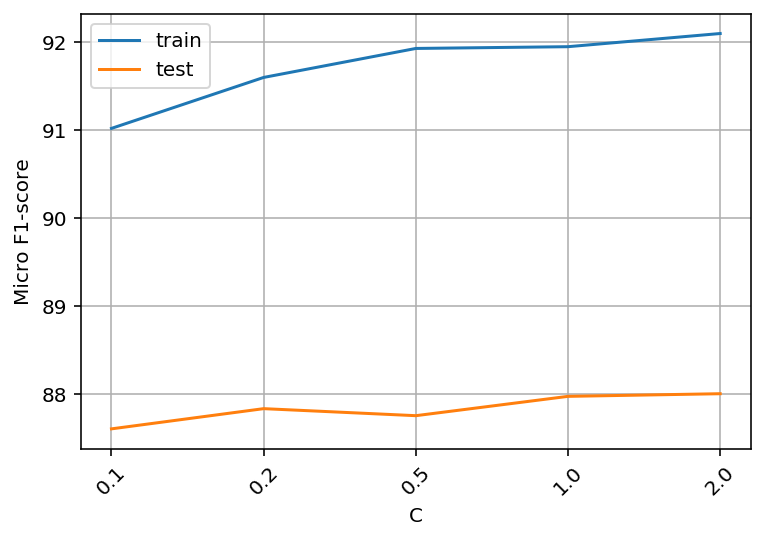

In [33]:
# plot train F1-score and test F1-score

fig = plt.figure(1)
ax  = fig.add_subplot(111)
a = np.arange(len(summary))

plt.plot(summary['Micro F1-score - Train'], label='train')
plt.plot(summary['Micro F1-score - Test'], label='test')
ax.xaxis.set_ticks(a)
ax.xaxis.set_ticklabels(range_C, rotation=45)
plt.xlabel('C')
plt.ylabel('Micro F1-score', rotation=90)
plt.legend()
plt.grid(True)

Since the model starts to overfit and test score remains constant after C = 2.0, we will select 2.0 for C.

Calculating Testing Metrics for C = 2.0

Confusion Matrix:
[[6224  505]
 [ 802 3443]]

Avg Accuracy: 88.09%

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      6729
           1       0.87      0.81      0.84      4245

    accuracy                           0.88     10974
   macro avg       0.88      0.87      0.87     10974
weighted avg       0.88      0.88      0.88     10974

Precision: 88.05%
Recall: 88.09%
F1 score: 88.0%


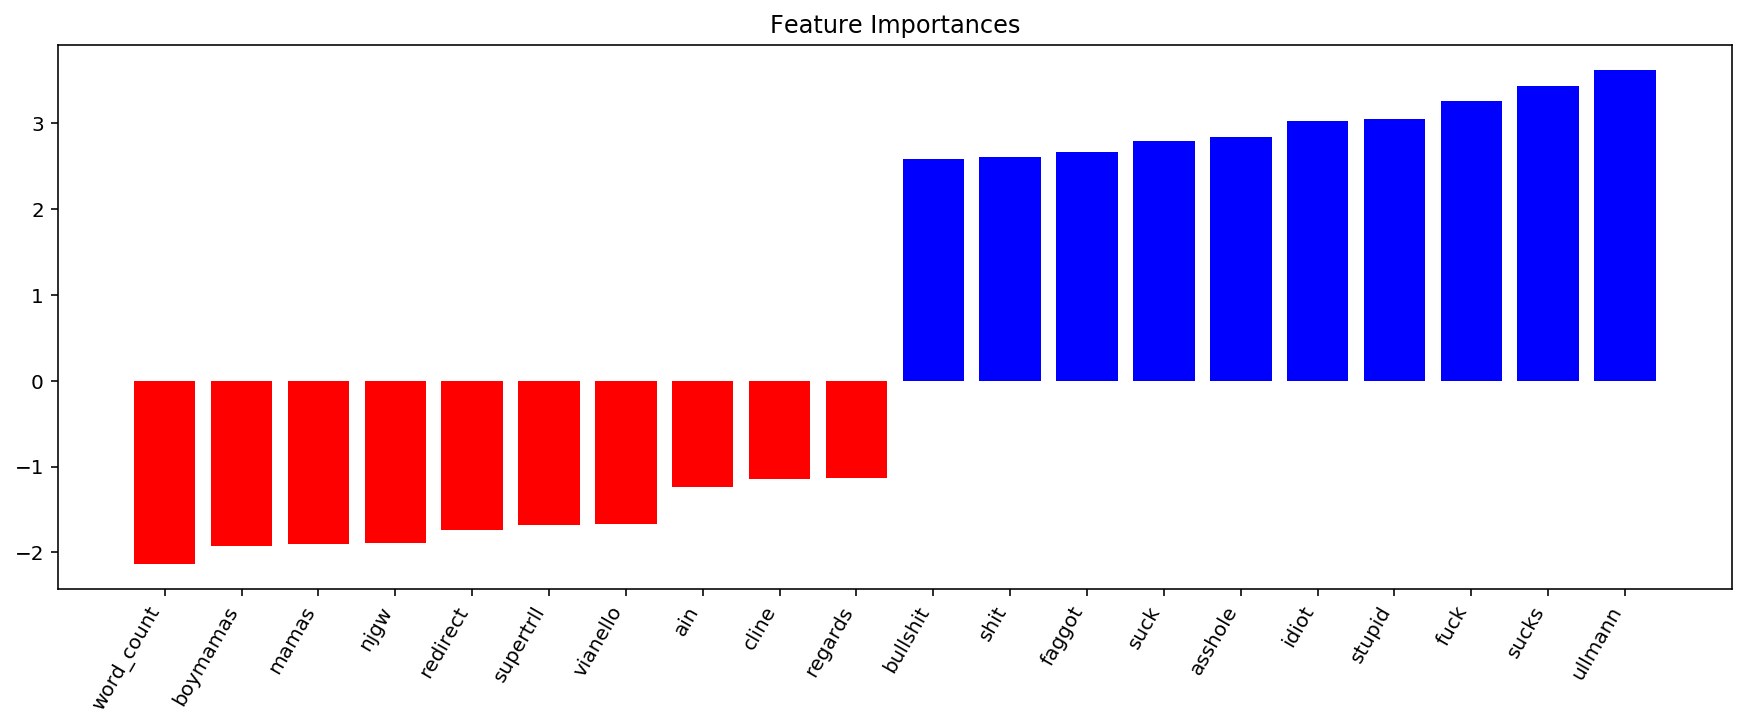

In [34]:
# detailed Test results for C = 2.0

print('Calculating Testing Metrics for C = 2.0')
test_pred = pipelines[4].predict(X_test)    
    
report = """
Confusion Matrix:
{}
\nAvg Accuracy: {}%
""".format(confusion_matrix(y_test, test_pred),
           round(100*accuracy_score(y_test, test_pred), 2))
print(report)

print('Classification Report:')
print(classification_report(y_test, test_pred))

precision, recall, f1_score, support = precision_recall_fscore_support(y_test, test_pred, beta=1, average='weighted')

print("Precision: {}%".format(np.round(100*precision, 2)))
print("Recall: {}%".format(np.round(100*recall, 2)))
print("F1 score: {}%".format(np.round(100*f1_score, 2)))

feature_importances = Get_Feature_Importances(pipelines[4])
Plot_Feature_Importances(feature_importances) 

In [35]:
# saving the model

filename = 'Count_LR_Level_1.joblib'
joblib.dump(pipelines[4], filename)

['Count_LR_Level_1.joblib']